In [37]:
import numpy as np
import pandas as pd
import yfinance as yf
import iisignature
from scipy.optimize import minimize
from numba import jit
import matplotlib.pyplot as plt
import random
from scipy.stats import ks_2samp, wasserstein_distance
from scipy.stats import chi2

# Data

In [2]:
# period
start_date = "2010-01-01"
end_date = "2026-01-01"

# universe
tickers = {
    "S&P 500": "^GSPC",
    "DJIA": "^DJI",
    "Nasdaq": "^IXIC",
}

prices = yf.download(
    list(tickers.values()), start=start_date, end=end_date, 
    auto_adjust=False, progress=False)["Close"]

## 1 path each year

In [3]:
# build train paths
true_paths = [prices.loc[prices.index.year==i,"^GSPC"].values[:250] for i in range(2010,2025)]
true_paths_multi = [p/p[0] for p in true_paths] # normalized

ts_multi = np.linspace(0, 249, 250)
dt_true = (ts_multi[-1] - ts_multi[0]) / (len(ts_multi) - 1)
# detrend paths
true_paths_residuals_multi = []
trend_lines_multi = []
for path in true_paths_multi:
    trend_coeffs = np.polyfit(ts_multi, path, 1)
    trend = np.polyval(trend_coeffs, ts_multi)
    true_paths_residuals_multi.append(path - trend)
    trend_lines_multi.append(trend)
    
train_logs_multi_ori = [np.log(prices.loc[prices.index.year==i,"^GSPC"].values[:250]) for i in range(2010,2025)]
train_logs_multi = [p/p[0] for p in train_logs_multi_ori] # normalized

## 1 path

In [4]:
# build train paths
true_paths = [prices.loc[prices.index.year<2025,"^GSPC"].values]
true_paths_one = [p/p[0] for p in true_paths] # normalized

ts_one = np.linspace(0, len(true_paths_one[0])-1, len(true_paths_one[0]))
dt_true = (ts_one[-1] - ts_one[0]) / (len(ts_one) - 1)
# detrend paths
true_paths_residuals_one = []
trend_lines_one = []
for path in true_paths_one:
    trend_coeffs = np.polyfit(ts_one, path, 1)
    trend = np.polyval(trend_coeffs, ts_one)
    true_paths_residuals_one.append(path - trend)
    trend_lines_one.append(trend)
    
train_logs_one_ori = [np.log(prices.loc[prices.index.year<2025,"^GSPC"].values)]
train_logs_one = [p/p[0] for p in train_logs_one_ori] # normalized

# Common functions

In [5]:
# paths: array of arrays of prices, ts: time index 1,2,3,4...
def get_path_signatures(ts, paths, window_size, sig_level, logsig):
    """
    Calculates signatures for all sliding windows of a collection of paths.
    """
    all_signatures = []
    for path in paths:
        current_ts = ts[:len(path)]
        path_2d = np.stack([current_ts, path], axis=1)
        for i in range(len(path) - window_size + 1):
            window = path_2d[i : i + window_size]
            if logsig == False:
                sig = iisignature.sig(window, sig_level)
            else:
                s = iisignature.prepare(2, sig_level, 'S')
                sig = iisignature.logsig(window, s)
            all_signatures.append(sig)
    return np.array(all_signatures)

def mmd_signature_linear(ts, paths1, paths2, window_size, sig_level):
    """
    Calculates the MMD between two collections of paths using the linear signature kernel.
    This is the squared Euclidean distance between the mean signatures.
    """
    sigs1 = get_path_signatures(ts, paths1, window_size, sig_level, False)
    sigs2 = get_path_signatures(ts, paths2, window_size, sig_level, False)

    if sigs1.shape[0] == 0 or sigs2.shape[0] == 0:
        return 0.0

    mean_sig1 = np.mean(sigs1, axis=0)
    mean_sig2 = np.mean(sigs2, axis=0)

    mmd_sq = np.sum((mean_sig1 - mean_sig2)**2)
    return mmd_sq

# Model 1: path-wise bootstrap

## Functions

In [6]:
def build_bootstrap_library_pathwise(ts, paths, lookback, sig_level, forward_window, logsig):
    """Builds the library of (signature, future_path_segment) pairs."""
    signatures_list, future_segments_list = [], []
    for path in paths:
        path_2d = np.stack([ts[:len(path)], path], axis=1)
        for i in range(lookback, len(path) - forward_window):
            window_2d = path_2d[i - lookback : i + 1]
            if logsig == False:
                sig = iisignature.sig(window_2d, sig_level)
            else:
                s = iisignature.prepare(2, sig_level, 'S')
                sig = iisignature.logsig(window_2d, s)
            start_val = path[i]
            '''here if path is log-return, then why do we need to minus start_val'''
            future_segment = path[i+1 : i + 1 + forward_window] - start_val   

            signatures_list.append(sig)
            future_segments_list.append(future_segment)
    return np.array(signatures_list), np.array(future_segments_list)

# K-NN part. seed_path: pregiven path start longer than lookback, n_tot_step: len of the wholde path want
def generate_path_bootstrap_pathwise(seed_path, n_total_steps, lookback, sig_level, dt, library_sigs, library_segments, logsig, k, SEED):
    """Generates a full path by appending historical path segments."""
    gen_path_list = list(seed_path)
    forward_window = library_segments.shape[1]

    while len(gen_path_list) < n_total_steps:
        current_lookback_path = np.array(gen_path_list[-(lookback+1):])
        time_segment = np.arange(len(current_lookback_path)) * dt
        current_window = np.stack([time_segment, current_lookback_path], axis=1)
        if logsig == False:
                query_sig = iisignature.sig(current_window, sig_level)
        else:
            s = iisignature.prepare(2, sig_level, 'S')
            query_sig = iisignature.logsig(current_window, s)
        distances = np.linalg.norm(library_sigs - query_sig, axis=1)
        neighbor_indices = np.argsort(distances)[:k]
        if SEED:
            rng = np.random.default_rng(SEED)
            chosen_neighbor_idx = rng.choice(neighbor_indices)
        else:
            chosen_neighbor_idx = np.random.choice(neighbor_indices)
        chosen_segment = library_segments[chosen_neighbor_idx]
        next_segment = gen_path_list[-1] + chosen_segment
        gen_path_list.extend(list(next_segment))

    return np.array(gen_path_list)[:n_total_steps]

## Train (year by year)

In [7]:
LOOKBACK = 20
SIG_LEVEL = 3
BOOTSTRAP_FORWARD_WINDOW = 5
N_PATHS_TO_GENERATE = 50
T_SIZE = len(true_paths_multi[0])
N_GROUND_TRUTH_PATHS = len(true_paths_multi)
k = 10
SEED = 1234


# given detrend paths data: true_paths_residuals
bootstrap_library_sigs, bootstrap_library_segments = build_bootstrap_library_pathwise(ts_multi, true_paths_residuals_multi, LOOKBACK, SIG_LEVEL, BOOTSTRAP_FORWARD_WINDOW,False)

all_bootstrap_paths_multi = []
for i in range(N_PATHS_TO_GENERATE):
    # Use a consistent seed path from the de-trended data
    seed_path_residuals = true_paths_residuals_multi[i % N_GROUND_TRUTH_PATHS][:LOOKBACK+1]
    trend_to_add = trend_lines_multi[i % N_GROUND_TRUTH_PATHS] 
    # Generate residual paths and add the trend back
    bootstrap_residuals_gen = generate_path_bootstrap_pathwise(seed_path_residuals, T_SIZE, LOOKBACK, SIG_LEVEL, dt_true, bootstrap_library_sigs, bootstrap_library_segments, False, k,SEED)
    all_bootstrap_paths_multi.append(bootstrap_residuals_gen + trend_to_add)
    
# Evaluate
MMD_WINDOW_SIZE = 15
mmd_bootstrap = mmd_signature_linear(ts_multi, true_paths_multi, all_bootstrap_paths_multi, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Path-wise Bootstrap):   {mmd_bootstrap:.6f}")

   - Linear Sig-MMD^2 (Path-wise Bootstrap):   0.018412


In [ ]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for path in true_paths_multi:
    ax1_boot.plot(ts_multi, path, color='black', alpha=0.6)
for p in all_bootstrap_paths_multi:
    ax1_boot.plot(ts_multi[:len(p)], p, color='blue', alpha=0.5)
ax1_boot.set_title(f'Model 1: Path-wise Bootstrap (Linear Sig-MMD²={mmd_bootstrap:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (Bootstrap)'])

## Train (1 path)

In [9]:
LOOKBACK = 20
SIG_LEVEL = 3
BOOTSTRAP_FORWARD_WINDOW = 5
N_PATHS_TO_GENERATE = 10
T_SIZE = len(true_paths_one[0])
N_GROUND_TRUTH_PATHS = len(true_paths_one)
k = 10
SEED = None

# given detrend paths data: true_paths_residuals
bootstrap_library_sigs, bootstrap_library_segments = build_bootstrap_library_pathwise(ts_one, true_paths_residuals_one, LOOKBACK, SIG_LEVEL, BOOTSTRAP_FORWARD_WINDOW, False)

all_bootstrap_paths_one = []
for i in range(N_PATHS_TO_GENERATE):
    # Use a consistent seed path from the de-trended data
    seed_path_residuals = true_paths_residuals_one[i % N_GROUND_TRUTH_PATHS][:LOOKBACK+1]
    trend_to_add = trend_lines_one[i % N_GROUND_TRUTH_PATHS] 
    # Generate residual paths and add the trend back
    bootstrap_residuals_gen = generate_path_bootstrap_pathwise(seed_path_residuals, T_SIZE, LOOKBACK, SIG_LEVEL, dt_true, bootstrap_library_sigs, bootstrap_library_segments, False, k,SEED)
    all_bootstrap_paths_one.append(bootstrap_residuals_gen + trend_to_add)
    
# Evaluate
MMD_WINDOW_SIZE = 15
mmd_bootstrap = mmd_signature_linear(ts_one, true_paths_one, all_bootstrap_paths_one, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Path-wise Bootstrap):   {mmd_bootstrap:.6f}")

   - Linear Sig-MMD^2 (Path-wise Bootstrap):   0.008518


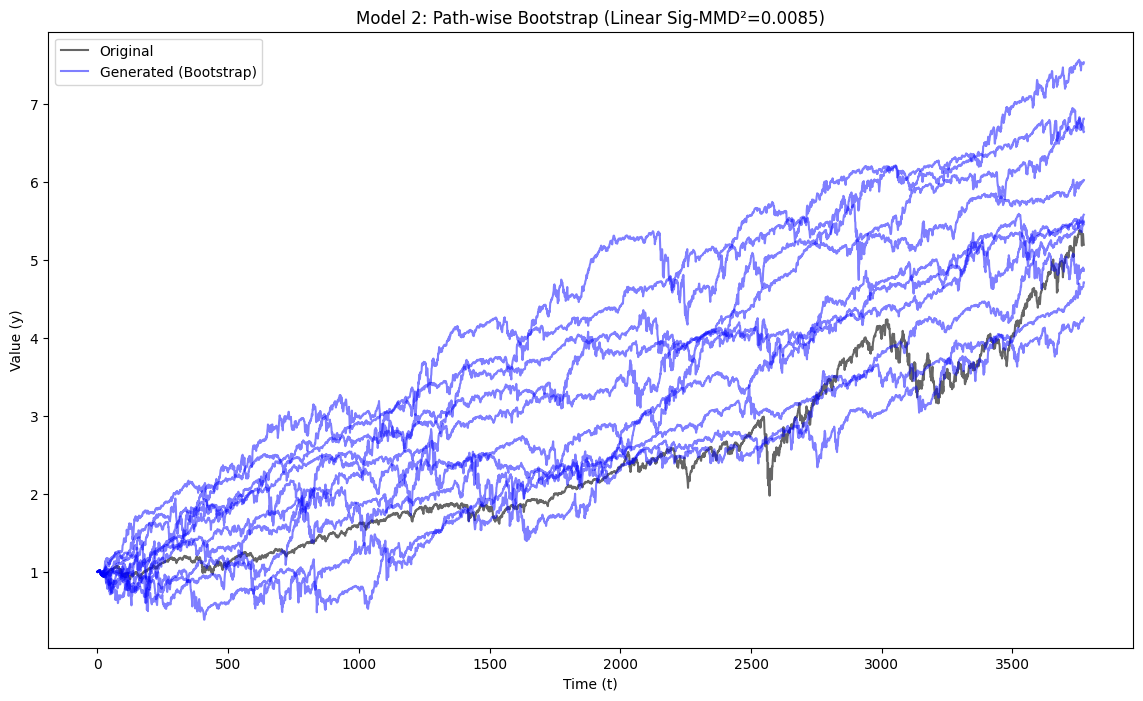

In [10]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for path in true_paths_one:
    ax1_boot.plot(ts_one, path, color='black', alpha=0.6)
for p in all_bootstrap_paths_one:
    ax1_boot.plot(ts_one[:len(p)], p, color='blue', alpha=0.5)
ax1_boot.set_title(f'Model 2: Path-wise Bootstrap (Linear Sig-MMD²={mmd_bootstrap:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (Bootstrap)'])

## Train year by year on logsig

In [11]:
LOOKBACK = 20
SIG_LEVEL = 3
BOOTSTRAP_FORWARD_WINDOW = 5
N_PATHS_TO_GENERATE = 50
T_SIZE = len(true_paths_multi[0])
N_GROUND_TRUTH_PATHS = len(true_paths_multi)
k = 10
SEED = 1234
logsig = True

# given detrend paths data: true_paths_residuals
bootstrap_library_sigs, bootstrap_library_segments = build_bootstrap_library_pathwise(ts_multi, true_paths_residuals_multi, LOOKBACK, SIG_LEVEL, BOOTSTRAP_FORWARD_WINDOW,logsig)

all_bootstrap_paths_multi_log = []
for i in range(N_PATHS_TO_GENERATE):
    # Use a consistent seed path from the de-trended data
    seed_path_residuals = true_paths_residuals_multi[i % N_GROUND_TRUTH_PATHS][:LOOKBACK+1]
    trend_to_add = trend_lines_multi[i % N_GROUND_TRUTH_PATHS] 
    # Generate residual paths and add the trend back
    bootstrap_residuals_gen = generate_path_bootstrap_pathwise(seed_path_residuals, T_SIZE, LOOKBACK, SIG_LEVEL, dt_true, bootstrap_library_sigs, bootstrap_library_segments, logsig, k, SEED)
    all_bootstrap_paths_multi_log.append(bootstrap_residuals_gen + trend_to_add)
    
# Evaluate
MMD_WINDOW_SIZE = 15
mmd_bootstrap = mmd_signature_linear(ts_multi, true_paths_multi, all_bootstrap_paths_multi_log, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Path-wise Bootstrap):   {mmd_bootstrap:.6f}")

   - Linear Sig-MMD^2 (Path-wise Bootstrap):   0.028589


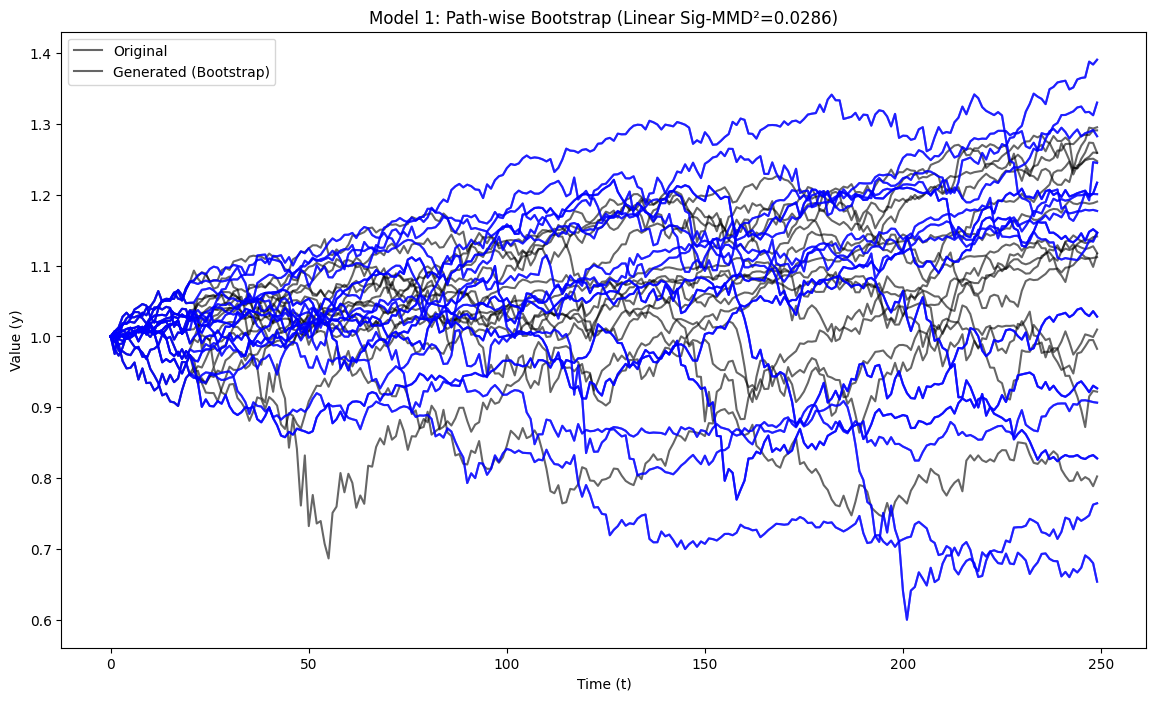

In [12]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for path in true_paths_multi:
    ax1_boot.plot(ts_multi, path, color='black', alpha=0.6)
for p in all_bootstrap_paths_multi_log:
    ax1_boot.plot(ts_multi[:len(p)], p, color='blue', alpha=0.5)
ax1_boot.set_title(f'Model 1: Path-wise Bootstrap (Linear Sig-MMD²={mmd_bootstrap:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (Bootstrap)'])

## Trian 1 path with logsig

In [13]:
LOOKBACK = 20
SIG_LEVEL = 3
BOOTSTRAP_FORWARD_WINDOW = 5
N_PATHS_TO_GENERATE = 10
T_SIZE = len(true_paths_one[0])
N_GROUND_TRUTH_PATHS = len(true_paths_one)
k = 10
SEED = None

# given detrend paths data: true_paths_residuals
bootstrap_library_sigs, bootstrap_library_segments = build_bootstrap_library_pathwise(ts_one, true_paths_residuals_one, LOOKBACK, SIG_LEVEL, BOOTSTRAP_FORWARD_WINDOW,logsig)

all_bootstrap_paths_one_log = []
for i in range(N_PATHS_TO_GENERATE):
    # Use a consistent seed path from the de-trended data
    seed_path_residuals = true_paths_residuals_one[i % N_GROUND_TRUTH_PATHS][:LOOKBACK+1]
    trend_to_add = trend_lines_one[i % N_GROUND_TRUTH_PATHS] 
    # Generate residual paths and add the trend back
    bootstrap_residuals_gen = generate_path_bootstrap_pathwise(seed_path_residuals, T_SIZE, LOOKBACK, SIG_LEVEL, dt_true, bootstrap_library_sigs, bootstrap_library_segments,logsig, k, SEED)
    all_bootstrap_paths_one_log.append(bootstrap_residuals_gen + trend_to_add)
    
# Evaluate
MMD_WINDOW_SIZE = 15
mmd_bootstrap = mmd_signature_linear(ts_one, true_paths_one, all_bootstrap_paths_one_log, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Path-wise Bootstrap):   {mmd_bootstrap:.6f}")

   - Linear Sig-MMD^2 (Path-wise Bootstrap):   0.116951


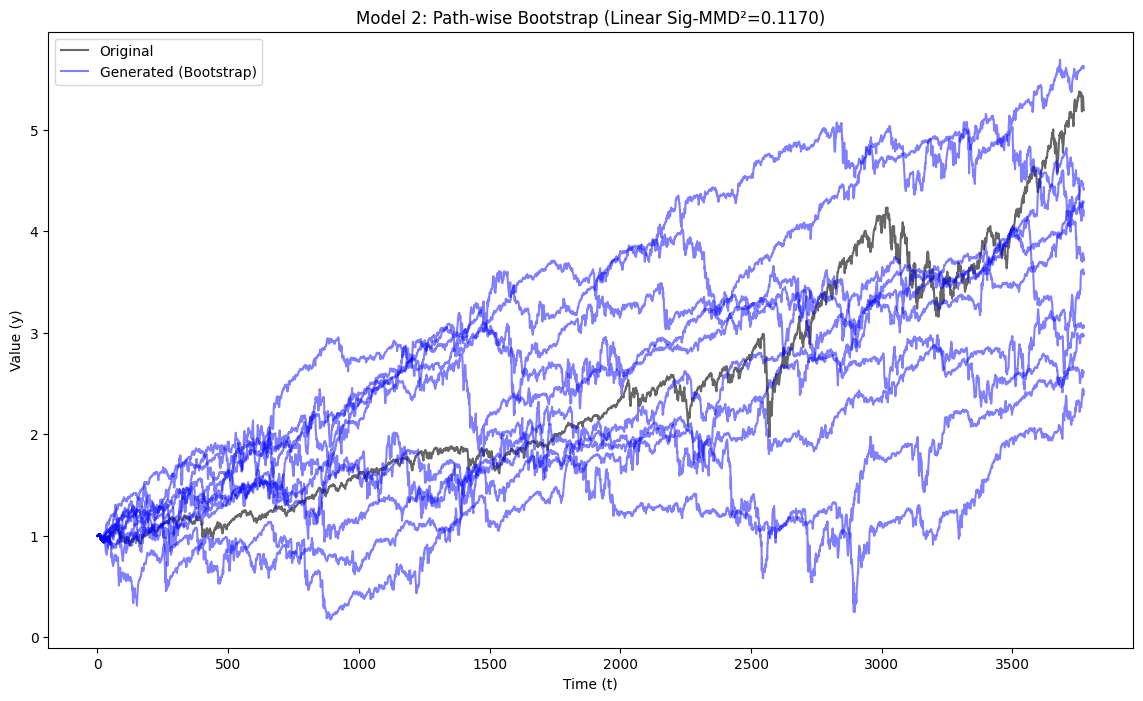

In [14]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for path in true_paths_one:
    ax1_boot.plot(ts_one, path, color='black', alpha=0.6)
for p in all_bootstrap_paths_one_log:
    ax1_boot.plot(ts_one[:len(p)], p, color='blue', alpha=0.5)
ax1_boot.set_title(f'Model 2: Path-wise Bootstrap (Linear Sig-MMD²={mmd_bootstrap:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (Bootstrap)'])

# Model 2: hybrid SDE

## Function

In [15]:
@jit(nopython=True)
def get_mu_model(params, y):
    """Calculates drift: mu(y) = c*y. A simple mean-reverting model."""
    c = params[0]
    return c * y

@jit(nopython=True)
def loss_function_numba(params, dS, y_levels, dt, reg_strength):
    """Numba-accelerated loss function for the simple mean-reverting drift model."""
    params_mu = params
    mu_t = np.empty(len(y_levels))
    for i in range(len(y_levels)):
        y = y_levels[i]
        mu_t[i] = get_mu_model(params_mu, y)

    residuals = dS - mu_t * dt
    loss = np.sum(residuals**2) + reg_strength * np.sum(params**2)
    return loss

def loss_function_wrapper(params, dS, y_levels, dt, reg_strength):
    return loss_function_numba(params, dS, y_levels, dt, reg_strength)

# here the forward save the de-predicted trend residual (just one step each time)
def build_hybrid_library(ts, paths, lookback, sig_level, params_mu, dt, logsig):
    """Builds a library of (signature, residual) pairs for the hybrid model."""
    signatures_list, residuals_list = [], []
    for path in paths:
        path_2d = np.stack([ts[:len(path)], path], axis=1)
        dS_path = np.diff(path)
        for i in range(lookback, len(path) - 1):
            window_2d = path_2d[i - lookback : i + 1]
            if logsig == False:
                sig = iisignature.sig(window_2d, sig_level)
            else:
                s = iisignature.prepare(2, sig_level, 'S')
                sig = iisignature.logsig(window_2d, s)
            y_i = path[i]
            predicted_drift = get_mu_model(params_mu, y_i) * dt
            actual_increment = dS_path[i]
            residual = actual_increment - predicted_drift

            signatures_list.append(sig)
            residuals_list.append(residual)

    return np.array(signatures_list), np.array(residuals_list)

def generate_path_hybrid(seed_path, n_total_steps, lookback, sig_level, dt, params_mu, library_sigs, library_residuals, logsig, k, SEED):
    """Generates a path using the hybrid SDE-bootstrap method."""
    gen_path_list = list(seed_path)
    for i in range(n_total_steps - len(seed_path)):
        current_y = gen_path_list[-1]
        predicted_drift = get_mu_model(params_mu, current_y) * dt

        current_lookback_path = np.array(gen_path_list[-(lookback+1):])
        time_segment = np.arange(len(current_lookback_path)) * dt
        current_window = np.stack([time_segment, current_lookback_path], axis=1)
        query_sig = iisignature.sig(current_window, sig_level)
        if logsig == False:
            query_sig = iisignature.sig(current_window, sig_level)
        else:
            s = iisignature.prepare(2, sig_level, 'S')
            query_sig = iisignature.logsig(current_window, s)
        distances = np.linalg.norm(library_sigs - query_sig, axis=1)
        neighbor_indices = np.argsort(distances)[:k]
        if SEED:
            rng = np.random.default_rng(SEED)
            chosen_neighbor_idx = rng.choice(neighbor_indices)
        else:
            chosen_neighbor_idx = np.random.choice(neighbor_indices)

        sampled_residual = library_residuals[chosen_neighbor_idx]
        next_val = current_y + predicted_drift + sampled_residual
        gen_path_list.append(next_val)

    return np.array(gen_path_list)

## Train (year by year)

In [16]:
LOOKBACK = 20
SIG_LEVEL = 3
BOOTSTRAP_FORWARD_WINDOW = 5
N_PATHS_TO_GENERATE = 50
T_SIZE = len(true_paths_multi[0])
N_GROUND_TRUTH_PATHS = len(true_paths_multi)
REG_STRENGTH = 1.0
k = 10
SEED = 1234
logsig = False
    
# Train the drift model on the de-trended residuals
all_dS_residuals, all_y_levels_residuals = [], []
for path in true_paths_residuals_multi:
    dS_path = np.diff(path)
    for i in range(LOOKBACK, len(path) - 1):
        all_dS_residuals.append(dS_path[i])
        all_y_levels_residuals.append(path[i])

dS_full_aligned = np.array(all_dS_residuals)
y_levels_full = np.array(all_y_levels_residuals)

mu_param_count = 1
initial_params = np.array([-0.1])

res = minimize(loss_function_wrapper, initial_params,
               args=(dS_full_aligned, y_levels_full, dt_true, REG_STRENGTH),
               method='L-BFGS-B', options={'maxiter': 500})

params_mu_opt_multi = res.x

hybrid_library_sigs, hybrid_library_residuals = build_hybrid_library(ts_multi, true_paths_residuals_multi, LOOKBACK, SIG_LEVEL, params_mu_opt_multi, dt_true, logsig)

all_hybrid_paths_multi = []

for i in range(N_PATHS_TO_GENERATE):
    # Use a consistent seed path from the de-trended data
    seed_path_residuals = true_paths_residuals_multi[i % N_GROUND_TRUTH_PATHS][:LOOKBACK+1]
    trend_to_add = trend_lines_multi[i % N_GROUND_TRUTH_PATHS]
    # Generate residual paths and add the trend back
    hybrid_residuals_gen = generate_path_hybrid(seed_path_residuals, T_SIZE, LOOKBACK, SIG_LEVEL, dt_true, params_mu_opt_multi, hybrid_library_sigs, hybrid_library_residuals,logsig, k, SEED)
    all_hybrid_paths_multi.append(hybrid_residuals_gen + trend_to_add)

# Evaluate
MMD_WINDOW_SIZE = 15
mmd_hybrid = mmd_signature_linear(ts_multi, true_paths_multi, all_hybrid_paths_multi, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Hybrid SDE Model):      {mmd_hybrid:.6f}")

   - Linear Sig-MMD^2 (Hybrid SDE Model):      0.000867


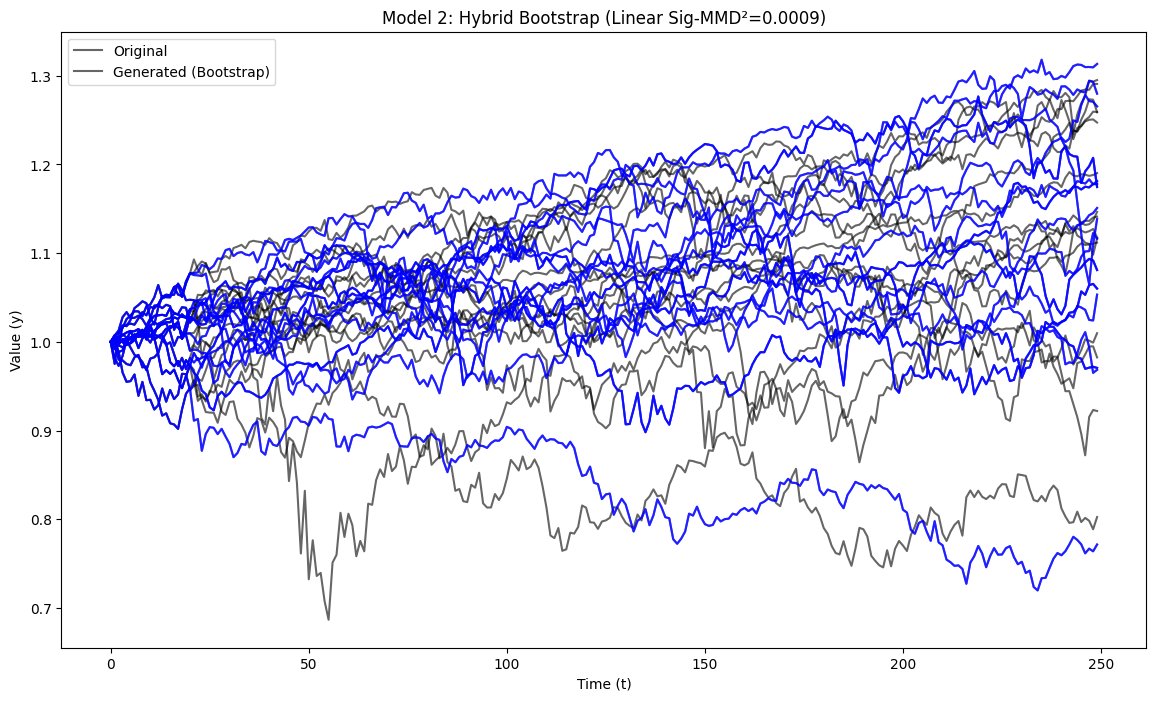

In [17]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for path in true_paths_multi:
    ax1_boot.plot(ts_multi, path, color='black', alpha=0.6)
for p in all_hybrid_paths_multi:
    ax1_boot.plot(ts_multi[:len(p)], p, color='blue', alpha=0.5)
ax1_boot.set_title(f'Model 2: Hybrid Bootstrap (Linear Sig-MMD²={mmd_hybrid:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (Bootstrap)'])

## Train (1 path)

In [18]:
LOOKBACK = 20
SIG_LEVEL = 3
BOOTSTRAP_FORWARD_WINDOW = 5
N_PATHS_TO_GENERATE = 10
T_SIZE = len(true_paths_one[0])
N_GROUND_TRUTH_PATHS = len(true_paths_one)
REG_STRENGTH = 1.0
k = 10
logsig = False
SEED = None

# Train the drift model on the de-trended residuals
all_dS_residuals, all_y_levels_residuals = [], []
for path in true_paths_residuals_one:
    dS_path = np.diff(path)
    for i in range(LOOKBACK, len(path) - 1):
        all_dS_residuals.append(dS_path[i])
        all_y_levels_residuals.append(path[i])

dS_full_aligned = np.array(all_dS_residuals)
y_levels_full = np.array(all_y_levels_residuals)

mu_param_count = 1
initial_params = np.array([-0.1])

res = minimize(loss_function_wrapper, initial_params,
               args=(dS_full_aligned, y_levels_full, dt_true, REG_STRENGTH),
               method='L-BFGS-B', options={'maxiter': 500})

params_mu_opt_one = res.x

hybrid_library_sigs, hybrid_library_residuals = build_hybrid_library(ts_one, true_paths_residuals_one, LOOKBACK, SIG_LEVEL, params_mu_opt_one, dt_true, logsig)

all_hybrid_paths_one = []

for i in range(N_PATHS_TO_GENERATE):
    # Use a consistent seed path from the de-trended data
    seed_path_residuals = true_paths_residuals_one[i % N_GROUND_TRUTH_PATHS][:LOOKBACK+1]
    trend_to_add = trend_lines_one[i % N_GROUND_TRUTH_PATHS]
    # Generate residual paths and add the trend back
    hybrid_residuals_gen = generate_path_hybrid(seed_path_residuals, T_SIZE, LOOKBACK, SIG_LEVEL, dt_true, params_mu_opt_one, hybrid_library_sigs, hybrid_library_residuals, logsig, k, SEED)
    all_hybrid_paths_one.append(hybrid_residuals_gen + trend_to_add)

# Evaluate
MMD_WINDOW_SIZE = 15
mmd_hybrid = mmd_signature_linear(ts_one, true_paths_one, all_hybrid_paths_one, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Hybrid SDE Model):      {mmd_hybrid:.6f}")

   - Linear Sig-MMD^2 (Hybrid SDE Model):      0.034129


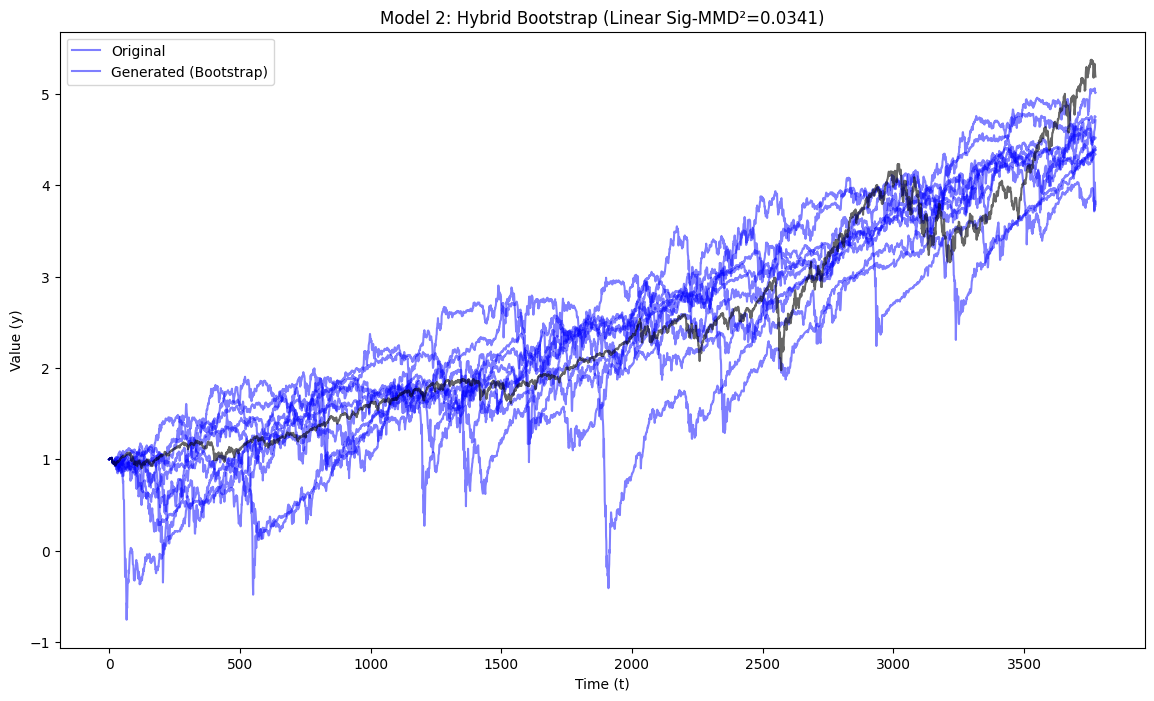

In [19]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for p in all_hybrid_paths_one:
    ax1_boot.plot(ts_one[:len(p)], p, color='blue', alpha=0.5)
for path in true_paths_one:
    ax1_boot.plot(ts_one, path, color='black', alpha=0.6)
ax1_boot.set_title(f'Model 2: Hybrid Bootstrap (Linear Sig-MMD²={mmd_hybrid:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (Bootstrap)'])

## Train year by year with logsig

In [20]:
LOOKBACK = 20
SIG_LEVEL = 3
BOOTSTRAP_FORWARD_WINDOW = 5
N_PATHS_TO_GENERATE = 50
T_SIZE = len(true_paths_multi[0])
N_GROUND_TRUTH_PATHS = len(true_paths_multi)
REG_STRENGTH = 1.0
k = 10
logsig = True
SEED = 1234

# Train the drift model on the de-trended residuals
all_dS_residuals, all_y_levels_residuals = [], []
for path in true_paths_residuals_multi:
    dS_path = np.diff(path)
    for i in range(LOOKBACK, len(path) - 1):
        all_dS_residuals.append(dS_path[i])
        all_y_levels_residuals.append(path[i])

dS_full_aligned = np.array(all_dS_residuals)
y_levels_full = np.array(all_y_levels_residuals)

mu_param_count = 1
initial_params = np.array([-0.1])

res = minimize(loss_function_wrapper, initial_params,
               args=(dS_full_aligned, y_levels_full, dt_true, REG_STRENGTH),
               method='L-BFGS-B', options={'maxiter': 500})

params_mu_opt_multi_log = res.x

hybrid_library_sigs, hybrid_library_residuals = build_hybrid_library(ts_multi, true_paths_residuals_multi, LOOKBACK, SIG_LEVEL, params_mu_opt_multi_log, dt_true,logsig)

all_hybrid_paths_multi_log = []

for i in range(N_PATHS_TO_GENERATE):
    # Use a consistent seed path from the de-trended data
    seed_path_residuals = true_paths_residuals_multi[i % N_GROUND_TRUTH_PATHS][:LOOKBACK+1]
    trend_to_add = trend_lines_multi[i % N_GROUND_TRUTH_PATHS]
    # Generate residual paths and add the trend back
    hybrid_residuals_gen = generate_path_hybrid(seed_path_residuals, T_SIZE, LOOKBACK, SIG_LEVEL, dt_true, params_mu_opt_multi_log, hybrid_library_sigs, hybrid_library_residuals, logsig, k, SEED)
    all_hybrid_paths_multi_log.append(hybrid_residuals_gen + trend_to_add)

# Evaluate
MMD_WINDOW_SIZE = 15
mmd_hybrid = mmd_signature_linear(ts_multi, true_paths_multi, all_hybrid_paths_multi_log, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Hybrid SDE Model):      {mmd_hybrid:.6f}")

   - Linear Sig-MMD^2 (Hybrid SDE Model):      0.004026


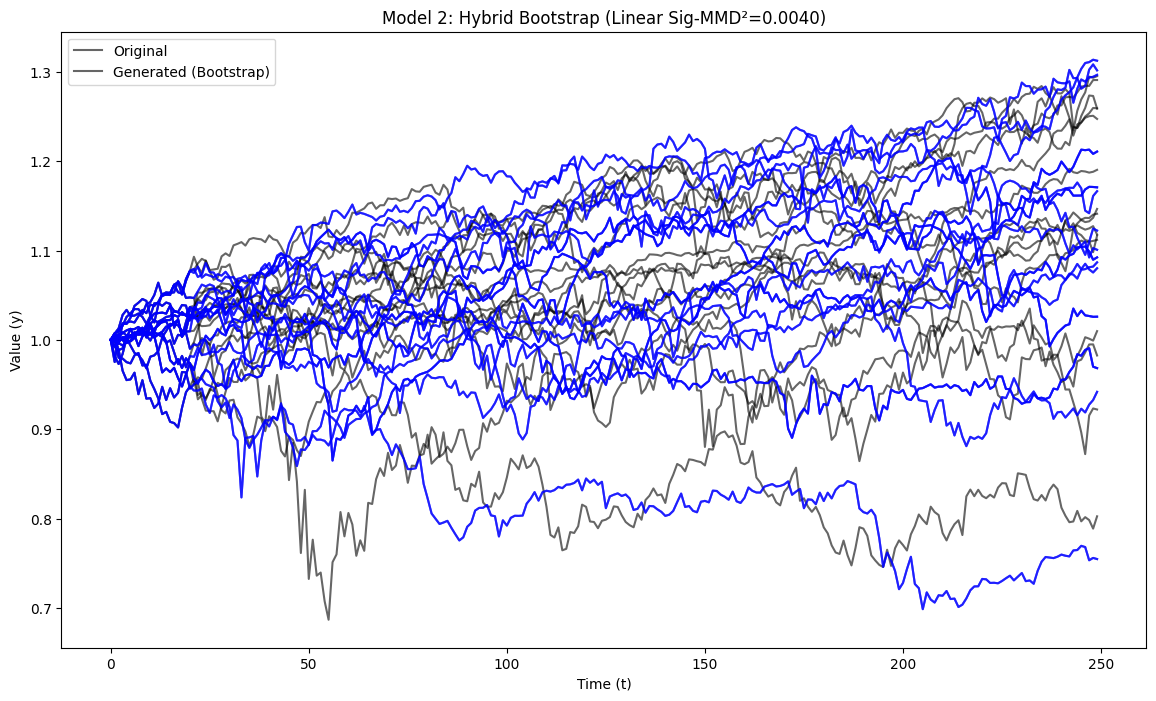

In [21]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for path in true_paths_multi:
    ax1_boot.plot(ts_multi, path, color='black', alpha=0.6)
for p in all_hybrid_paths_multi_log:
    ax1_boot.plot(ts_multi[:len(p)], p, color='blue', alpha=0.5)
ax1_boot.set_title(f'Model 2: Hybrid Bootstrap (Linear Sig-MMD²={mmd_hybrid:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (Bootstrap)'])

## Train 1 year with logsig

In [22]:
LOOKBACK = 20
SIG_LEVEL = 3
BOOTSTRAP_FORWARD_WINDOW = 5
N_PATHS_TO_GENERATE = 10
T_SIZE = len(true_paths_one[0])
N_GROUND_TRUTH_PATHS = len(true_paths_one)
REG_STRENGTH = 1.0
logsig= True
SEED = None
k = 10

# Train the drift model on the de-trended residuals
all_dS_residuals, all_y_levels_residuals = [], []
for path in true_paths_residuals_one:
    dS_path = np.diff(path)
    for i in range(LOOKBACK, len(path) - 1):
        all_dS_residuals.append(dS_path[i])
        all_y_levels_residuals.append(path[i])

dS_full_aligned = np.array(all_dS_residuals)
y_levels_full = np.array(all_y_levels_residuals)

mu_param_count = 1
initial_params = np.array([-0.1])

res = minimize(loss_function_wrapper, initial_params,
               args=(dS_full_aligned, y_levels_full, dt_true, REG_STRENGTH),
               method='L-BFGS-B', options={'maxiter': 500})

params_mu_opt_one_log = res.x

hybrid_library_sigs, hybrid_library_residuals = build_hybrid_library(ts_one, true_paths_residuals_one, LOOKBACK, SIG_LEVEL, params_mu_opt_one_log, dt_true,logsig)

all_hybrid_paths_one_log = []

for i in range(N_PATHS_TO_GENERATE):
    # Use a consistent seed path from the de-trended data
    seed_path_residuals = true_paths_residuals_one[i % N_GROUND_TRUTH_PATHS][:LOOKBACK+1]
    trend_to_add = trend_lines_one[i % N_GROUND_TRUTH_PATHS]
    # Generate residual paths and add the trend back
    hybrid_residuals_gen = generate_path_hybrid(seed_path_residuals, T_SIZE, LOOKBACK, SIG_LEVEL, dt_true, params_mu_opt_one_log, hybrid_library_sigs, hybrid_library_residuals,logsig, k, SEED)
    all_hybrid_paths_one_log.append(hybrid_residuals_gen + trend_to_add)

# Evaluate
MMD_WINDOW_SIZE = 15
mmd_hybrid = mmd_signature_linear(ts_one, true_paths_one, all_hybrid_paths_one_log, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Hybrid SDE Model):      {mmd_hybrid:.6f}")

   - Linear Sig-MMD^2 (Hybrid SDE Model):      0.046949


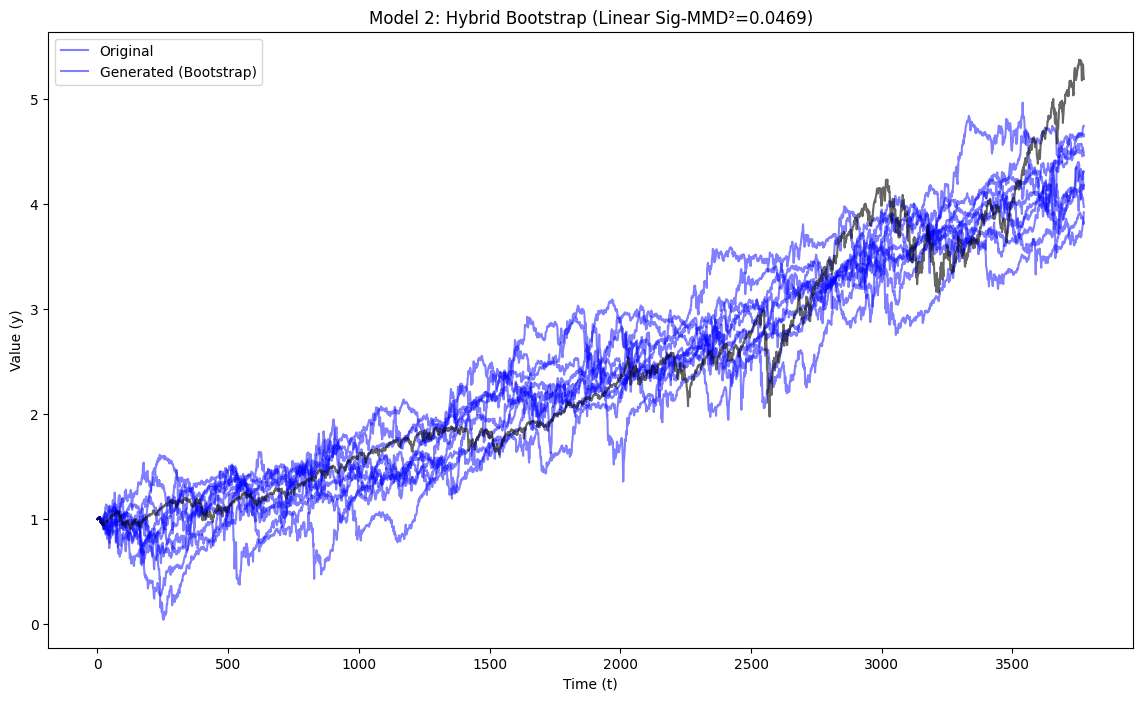

In [23]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for p in all_hybrid_paths_one_log:
    ax1_boot.plot(ts_one[:len(p)], p, color='blue', alpha=0.5)
for path in true_paths_one:
    ax1_boot.plot(ts_one, path, color='black', alpha=0.6)
ax1_boot.set_title(f'Model 2: Hybrid Bootstrap (Linear Sig-MMD²={mmd_hybrid:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (Bootstrap)'])

# Model 3: KRR model

## Function

In [24]:
def build_dataset(log_paths, lookback, sig_level, dt, logsig):
    S_list, y_mu, y_logsig = [], [], []
    for log_s in log_paths:
        n_steps = len(log_s)-1
        for i in range(lookback, n_steps):
            window = log_s[i-lookback:i+1]
            times  = np.linspace(0, lookback*dt, lookback+1)
            path2d = np.stack([times, window], axis=1)
            if logsig == False:
                sig = iisignature.sig(path2d, sig_level)
            else:
                s = iisignature.prepare(2, sig_level, 'S')
                sig = iisignature.logsig(path2d, s)
            S_list.append(sig)
            # drift target
            dlog = log_s[i+1] - log_s[i]
            y_mu.append(dlog/dt)
            # vol target
            past_rets = np.diff(window)
            sigma_est = np.std(past_rets) / np.sqrt(dt)
            y_logsig.append(np.log(sigma_est + 1e-8))
    S  = np.vstack(S_list)
    ym = np.array(y_mu)[:, None]
    ys = np.array(y_logsig)[:, None]
    return S, ym, ys

### KRR ###
def train_kernel_ridge(S, y, lam):
    # (K + lam I) alpha = y
    K = S @ S.T
    alpha = np.linalg.solve(K + lam*np.eye(K.shape[0]), y)
    return alpha, S

def predict(alpha, S_train, sig_new):
    k = S_train @ sig_new
    return (k @ alpha).item()

## Train (year by year)

Dataset: 3585 samples, 30 features
Training kernel ridge for drift and log-vol...
Generating 50 new paths with random seeding...


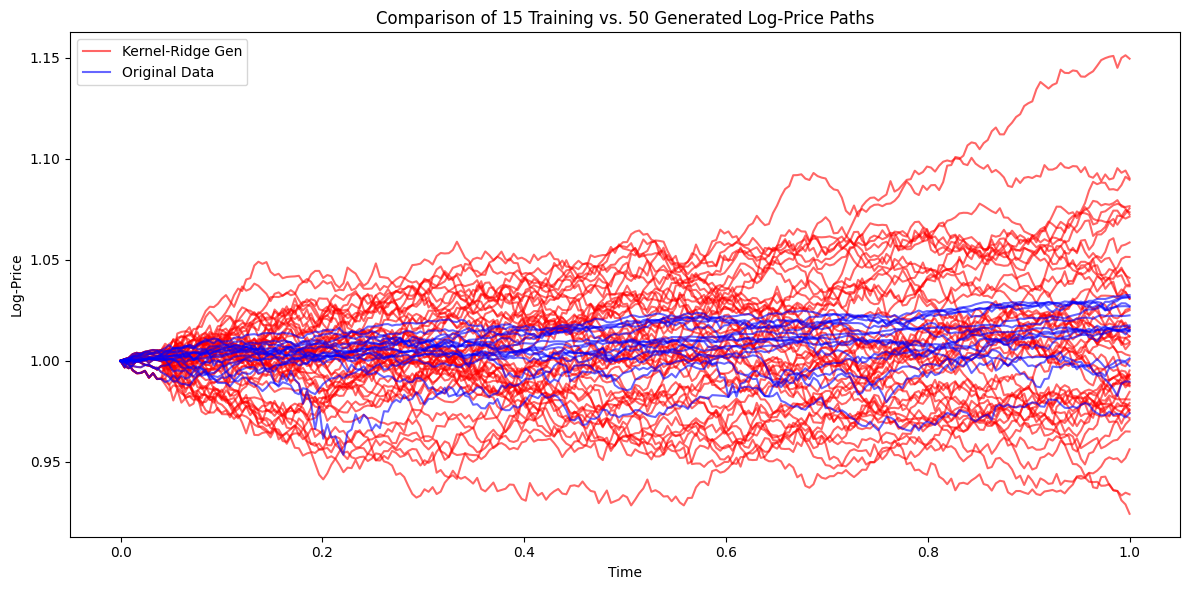

In [25]:
T, N_STEPS = 1, len(train_logs_multi[0])-1
LOOKBACK, SIG_LEVEL = 10, 4
N_PATHS, N_GEN = 15, 50
LAMBDA = 2.0
dt = T / N_STEPS
logsig = False
S_train, y_mu, y_logsig = build_dataset(train_logs_multi, LOOKBACK, SIG_LEVEL, dt,logsig)
print(f"Dataset: {S_train.shape[0]} samples, {S_train.shape[1]} features")

# 3. Train kernel ridge models
print("Training kernel ridge for drift and log-vol...")
alpha_mu, S_mu = train_kernel_ridge(S_train, y_mu, LAMBDA)
alpha_ls, S_ls = train_kernel_ridge(S_train, y_logsig, LAMBDA)

# 4. Generate new paths
print(f"Generating {N_GEN} new paths with random seeding...")
gen_logs_multi = []
# use first training path as seed for all generations
seed = train_logs_multi[0][:LOOKBACK+1]
for _ in range(N_GEN):
    # RANDOMLY SAMPLE A SEED FOR EACH NEW PATH
    rng = np.random.default_rng(SEED)
    seed_path = random.choice(train_logs_multi)
    seed_segment = seed_path[:LOOKBACK+1]

    log_gen = np.zeros(N_STEPS+1)
    log_gen[:LOOKBACK+1] = seed_segment

    for i in range(LOOKBACK, N_STEPS):
        window = log_gen[i-LOOKBACK:i+1]
        times  = np.linspace(0, LOOKBACK*dt, LOOKBACK+1)
        sig_new = iisignature.sig(np.stack([times, window],1), SIG_LEVEL)
        mu_pred = predict(alpha_mu, S_mu, sig_new)
        ls_pred = predict(alpha_ls, S_ls, sig_new)
        sigma_pred = np.exp(ls_pred)
        dW = np.random.randn() * np.sqrt(dt)
        log_gen[i+1] = log_gen[i] + mu_pred*dt + sigma_pred*dW
    gen_logs_multi.append(log_gen)

# 5. Plot training vs generated
t = np.linspace(0, T, N_STEPS+1)
plt.figure(figsize=(12,6))
for i in range(N_GEN):
    plt.plot(t, gen_logs_multi[i],   color='red',   alpha=0.6,
             label='Kernel-Ridge Gen' if i==0 else "")
for i in range(N_PATHS):
    plt.plot(t, train_logs_multi[i], color='blue',  alpha=0.6,
             label='Original Data' if i==0 else "")
plt.title(f'Comparison of {N_PATHS} Training vs. {N_GEN} Generated Log-Price Paths')
plt.xlabel('Time')
plt.ylabel('Log-Price')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
MMD_WINDOW_SIZE = 15
mmd_krr = mmd_signature_linear(t, train_logs_multi, gen_logs_multi, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Path-wise Bootstrap):   {mmd_krr}")

   - Linear Sig-MMD^2 (Path-wise Bootstrap):   2.0218544503313323e-09


## Train (1 path)

Dataset: 3763 samples, 30 features
Training kernel ridge for drift and log-vol...
Generating 15 new paths with random seeding...


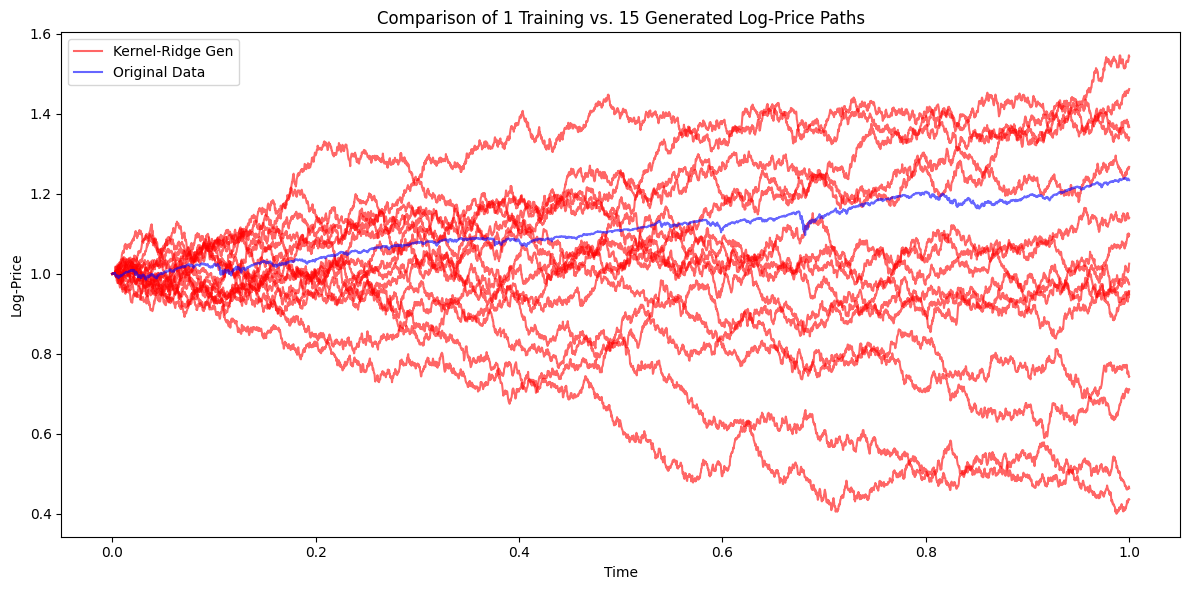

In [27]:
T, N_STEPS = 1, len(train_logs_one[0])-1
LOOKBACK, SIG_LEVEL = 10, 4
N_PATHS, N_GEN = 1, 15
LAMBDA = 2.0
logsig = False
dt = T / N_STEPS

S_train, y_mu, y_logsig = build_dataset(train_logs_one, LOOKBACK, SIG_LEVEL, dt, logsig)
print(f"Dataset: {S_train.shape[0]} samples, {S_train.shape[1]} features")

# 3. Train kernel ridge models
print("Training kernel ridge for drift and log-vol...")
alpha_mu, S_mu = train_kernel_ridge(S_train, y_mu, LAMBDA)
alpha_ls, S_ls = train_kernel_ridge(S_train, y_logsig, LAMBDA)

# 4. Generate new paths
print(f"Generating {N_GEN} new paths with random seeding...")
gen_logs_one = []
# use first training path as seed for all generations
seed = train_logs_one[0][:LOOKBACK+1]
for _ in range(N_GEN):
    # RANDOMLY SAMPLE A SEED FOR EACH NEW PATH
    seed_path = random.choice(train_logs_one)
    seed_segment = seed_path[:LOOKBACK+1]

    log_gen = np.zeros(N_STEPS+1)
    log_gen[:LOOKBACK+1] = seed_segment

    for i in range(LOOKBACK, N_STEPS):
        window = log_gen[i-LOOKBACK:i+1]
        times  = np.linspace(0, LOOKBACK*dt, LOOKBACK+1)
        sig_new = iisignature.sig(np.stack([times, window],1), SIG_LEVEL)
        mu_pred = predict(alpha_mu, S_mu, sig_new)
        ls_pred = predict(alpha_ls, S_ls, sig_new)
        # clip for noshock
        ls_pred = np.clip(ls_pred, np.percentile(y_logsig, 1), np.percentile(y_logsig, 99))
        sigma_pred = np.exp(ls_pred)
        dW = np.random.randn() * np.sqrt(dt)
        log_gen[i+1] = log_gen[i] + mu_pred*dt + sigma_pred*dW
    gen_logs_one.append(log_gen)

# 5. Plot training vs generated
t = np.linspace(0, T, N_STEPS+1)
plt.figure(figsize=(12,6))
for i in range(N_GEN):
    plt.plot(t, gen_logs_one[i],   color='red',   alpha=0.6,
             label='Kernel-Ridge Gen' if i==0 else "")
for i in range(N_PATHS):
    plt.plot(t, train_logs_one[i], color='blue',  alpha=0.6,
             label='Original Data' if i==0 else "")
plt.title(f'Comparison of {N_PATHS} Training vs. {N_GEN} Generated Log-Price Paths')
plt.xlabel('Time')
plt.ylabel('Log-Price')
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
MMD_WINDOW_SIZE = 15
mmd_krr = mmd_signature_linear(t, train_logs_one, gen_logs_one, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Path-wise Bootstrap):   {mmd_krr}")

   - Linear Sig-MMD^2 (Path-wise Bootstrap):   6.119611899692986e-07


## Train year by year with logsig

Dataset: 3585 samples, 8 features
Training kernel ridge for drift and log-vol...
Generating 50 new paths with random seeding...


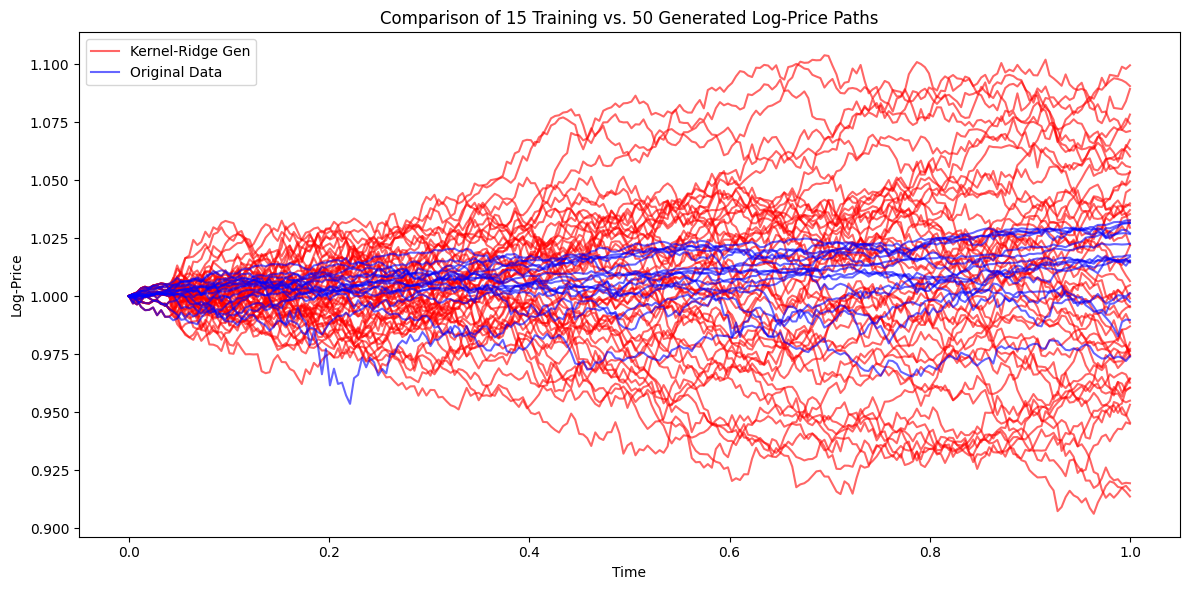

In [29]:
T, N_STEPS = 1, len(train_logs_multi[0])-1
LOOKBACK, SIG_LEVEL = 10, 4
N_PATHS, N_GEN = 15, 50
logsig = True
LAMBDA = 2.0

dt = T / N_STEPS

S_train, y_mu, y_logsig = build_dataset(train_logs_multi, LOOKBACK, SIG_LEVEL, dt,logsig)
print(f"Dataset: {S_train.shape[0]} samples, {S_train.shape[1]} features")

# 3. Train kernel ridge models
print("Training kernel ridge for drift and log-vol...")
alpha_mu, S_mu = train_kernel_ridge(S_train, y_mu, LAMBDA)
alpha_ls, S_ls = train_kernel_ridge(S_train, y_logsig, LAMBDA)

# 4. Generate new paths
print(f"Generating {N_GEN} new paths with random seeding...")
gen_logs_multi_log = []
# use first training path as seed for all generations
seed = train_logs_multi[0][:LOOKBACK+1]
for _ in range(N_GEN):
    # RANDOMLY SAMPLE A SEED FOR EACH NEW PATH
    seed_path = random.choice(train_logs_multi)
    seed_segment = seed_path[:LOOKBACK+1]

    log_gen = np.zeros(N_STEPS+1)
    log_gen[:LOOKBACK+1] = seed_segment

    for i in range(LOOKBACK, N_STEPS):
        window = log_gen[i-LOOKBACK:i+1]
        times  = np.linspace(0, LOOKBACK*dt, LOOKBACK+1)
        #sig_new = iisignature.sig(np.stack([times, window],1), SIG_LEVEL)
        s = iisignature.prepare(2, SIG_LEVEL, 'S')
        sig_new = iisignature.logsig(np.stack([times, window],1), s)
        mu_pred = predict(alpha_mu, S_mu, sig_new)
        ls_pred = predict(alpha_ls, S_ls, sig_new)
        sigma_pred = np.exp(ls_pred)
        dW = np.random.randn() * np.sqrt(dt)
        log_gen[i+1] = log_gen[i] + mu_pred*dt + sigma_pred*dW
    gen_logs_multi_log.append(log_gen)

# 5. Plot training vs generated
t = np.linspace(0, T, N_STEPS+1)
plt.figure(figsize=(12,6))
for i in range(N_GEN):
    plt.plot(t, gen_logs_multi_log[i],   color='red',   alpha=0.6,
             label='Kernel-Ridge Gen' if i==0 else "")
for i in range(N_PATHS):
    plt.plot(t, train_logs_multi[i], color='blue',  alpha=0.6,
             label='Original Data' if i==0 else "")
plt.title(f'Comparison of {N_PATHS} Training vs. {N_GEN} Generated Log-Price Paths')
plt.xlabel('Time')
plt.ylabel('Log-Price')
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
MMD_WINDOW_SIZE = 15
mmd_krr = mmd_signature_linear(t, train_logs_multi, gen_logs_multi_log, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Path-wise Bootstrap):   {mmd_krr}")

   - Linear Sig-MMD^2 (Path-wise Bootstrap):   1.3504824216178214e-07


Dataset: 3763 samples, 8 features
Training kernel ridge for drift and log-vol...
Generating 15 new paths with random seeding...


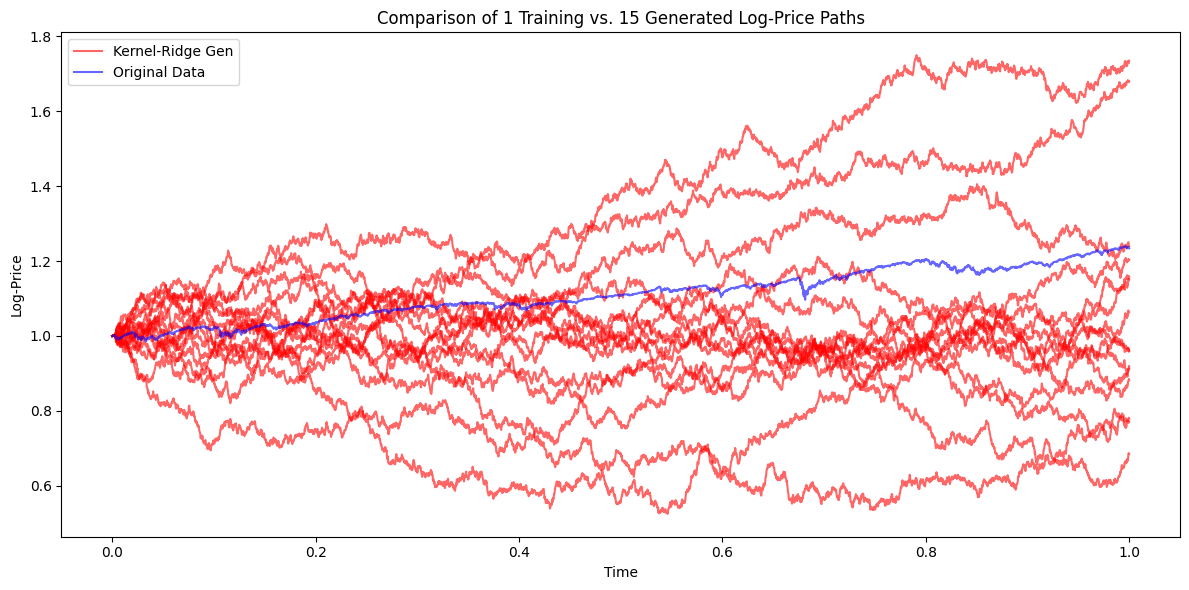

In [31]:
T, N_STEPS = 1, len(train_logs_one[0])-1
LOOKBACK, SIG_LEVEL = 10, 4
N_PATHS, N_GEN = 1, 15
LAMBDA = 2.0
logsig = True
dt = T / N_STEPS

S_train, y_mu, y_logsig = build_dataset(train_logs_one, LOOKBACK, SIG_LEVEL, dt, logsig)
print(f"Dataset: {S_train.shape[0]} samples, {S_train.shape[1]} features")

# 3. Train kernel ridge models
print("Training kernel ridge for drift and log-vol...")
alpha_mu, S_mu = train_kernel_ridge(S_train, y_mu, LAMBDA)
alpha_ls, S_ls = train_kernel_ridge(S_train, y_logsig, LAMBDA)

# 4. Generate new paths
print(f"Generating {N_GEN} new paths with random seeding...")
gen_logs_one_log = []
# use first training path as seed for all generations
seed = train_logs_one[0][:LOOKBACK+1]
for _ in range(N_GEN):
    # RANDOMLY SAMPLE A SEED FOR EACH NEW PATH
    seed_path = random.choice(train_logs_one)
    seed_segment = seed_path[:LOOKBACK+1]

    log_gen = np.zeros(N_STEPS+1)
    log_gen[:LOOKBACK+1] = seed_segment

    for i in range(LOOKBACK, N_STEPS):
        window = log_gen[i-LOOKBACK:i+1]
        times  = np.linspace(0, LOOKBACK*dt, LOOKBACK+1)
        #sig_new = iisignature.sig(np.stack([times, window],1), SIG_LEVEL)
        s = iisignature.prepare(2, SIG_LEVEL, 'S')
        sig_new = iisignature.logsig(np.stack([times, window],1), s)
        mu_pred = predict(alpha_mu, S_mu, sig_new)
        ls_pred = predict(alpha_ls, S_ls, sig_new)
        # clip for noshock
        ls_pred = np.clip(ls_pred, np.percentile(y_logsig, 1), np.percentile(y_logsig, 99))
        sigma_pred = np.exp(ls_pred)
        dW = np.random.randn() * np.sqrt(dt)
        log_gen[i+1] = log_gen[i] + mu_pred*dt + sigma_pred*dW
    gen_logs_one_log.append(log_gen)

# 5. Plot training vs generated
t = np.linspace(0, T, N_STEPS+1)
plt.figure(figsize=(12,6))
for i in range(N_GEN):
    plt.plot(t, gen_logs_one_log[i],   color='red',   alpha=0.6,
             label='Kernel-Ridge Gen' if i==0 else "")
for i in range(N_PATHS):
    plt.plot(t, train_logs_one[i], color='blue',  alpha=0.6,
             label='Original Data' if i==0 else "")
plt.title(f'Comparison of {N_PATHS} Training vs. {N_GEN} Generated Log-Price Paths')
plt.xlabel('Time')
plt.ylabel('Log-Price')
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
MMD_WINDOW_SIZE = 15
mmd_krr = mmd_signature_linear(t, train_logs_one, gen_logs_one_log, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Path-wise Bootstrap):   {mmd_krr}")

   - Linear Sig-MMD^2 (Path-wise Bootstrap):   4.066745963097663e-07


# Evaluation

idea:
1. Signature MMD
2. KS/Wasserstein tests （test on the distribution, different moment ）
3. Autocorrelation
4. build a ML model, train on simulated data, test on real data; or train on simulated+real data, test onn real out-sample data, see if it is better than just train on real data

## Method 1: calculate signature MMD

In [33]:
def get_path_signatures(ts, paths, window_size, sig_level, logsig):
    """
    Calculates signatures for all sliding windows of a collection of paths.
    """
    all_signatures = []
    for path in paths:
        current_ts = ts[:len(path)]
        path_2d = np.stack([current_ts, path], axis=1)
        for i in range(len(path) - window_size + 1):
            window = path_2d[i : i + window_size]
            if logsig == False:
                sig = iisignature.sig(window, sig_level)
            else:
                s = iisignature.prepare(2, sig_level, 'S')
                sig = iisignature.logsig(window, s)
            all_signatures.append(sig)
    return np.array(all_signatures)

def mmd_signature_linear(ts, paths1, paths2, window_size, sig_level):
    """
    Calculates the MMD between two collections of paths using the linear signature kernel.
    This is the squared Euclidean distance between the mean signatures.
    """
    sigs1 = get_path_signatures(ts, paths1, window_size, sig_level, False)
    sigs2 = get_path_signatures(ts, paths2, window_size, sig_level, False)

    if sigs1.shape[0] == 0 or sigs2.shape[0] == 0:
        return 0.0

    mean_sig1 = np.mean(sigs1, axis=0)
    mean_sig2 = np.mean(sigs2, axis=0)

    mmd_sq = np.sum((mean_sig1 - mean_sig2)**2)
    return mmd_sq

In [34]:
# eg
MMD_WINDOW_SIZE = 15
mmd_krr = mmd_signature_linear(t, train_logs_one, gen_logs_one_log, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Path-wise Bootstrap):   {mmd_krr}")

   - Linear Sig-MMD^2 (Path-wise Bootstrap):   4.066745963097663e-07


## Method 2: KS and Wasserstein tests

In [35]:
def extract_terminal_values(paths):
    return np.array([p[-1] for p in paths if len(p) >= 1], dtype=float)

def extract_terminal_logreturns(paths):
    """Return log(S_T/S_0) for each path."""
    out = []
    for p in paths:
        if len(p) >= 2:
            # if p is already log-levels, this reduces to p[-1]-p[0]
            out.append(np.log(p[-1]) - np.log(p[0]))
    return np.array(out, dtype=float)

def extract_all_returns(paths, use_log=True):
    """
    Concatenate per-step returns from every path.
    If use_log=True and inputs are levels, uses log-returns; if inputs are logs, it's just diffs.
    """
    out = []
    for p in paths:
        if len(p) >= 2:
            if use_log:
                r = np.diff(np.log(p))    
            else:
                r = np.diff(p)           
            out.append(r)
    return np.concatenate(out) if len(out) else np.array([], dtype=float)

def ks_and_wasserstein(x, y):
    """
    Run two-sample KS test and compute 1D Wasserstein distance between samples x and y.
    Returns a dict with the KS statistic & p-value and the Wasserstein distance.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    # Guard: if either sample is empty, return NaNs
    if x.size == 0 or y.size == 0:
        return {
            "ks_stat": np.nan,
            "ks_pvalue": np.nan,
            "wasserstein": np.nan,
            "nx": x.size,
            "ny": y.size
        }

    ks_stat, ks_pvalue = ks_2samp(x, y, alternative='two-sided', mode='auto')
    wdist = wasserstein_distance(x, y)
    return {
        "ks_stat": float(ks_stat),
        "ks_pvalue": float(ks_pvalue),
        "wasserstein": float(wdist),
        "nx": x.size,
        "ny": y.size
    }

In [36]:
x_term = extract_terminal_values(true_paths_multi)
y_term = extract_terminal_values(all_hybrid_paths_multi)
res_term = ks_and_wasserstein(x_term, y_term)
print("Terminal values:", res_term)

# 2) Compare terminal returns (log(S_T/S_0))
x_tr = extract_terminal_logreturns(true_paths_multi)
y_tr = extract_terminal_logreturns(all_hybrid_paths_multi)
res_tr = ks_and_wasserstein(x_tr, y_tr)
print("Terminal log-returns:", res_tr)

# 3) Compare per-step returns (concatenated across all paths)
#    If your paths are already logs, set use_log=True and it becomes diffs.
x_ret = extract_all_returns(true_paths_multi, use_log=True)
y_ret = extract_all_returns(all_hybrid_paths_multi, use_log=True)
res_ret = ks_and_wasserstein(x_ret, y_ret)
print("Per-step log-returns:", res_ret)


Terminal values: {'ks_stat': 0.22, 'ks_pvalue': 0.5618398383321263, 'wasserstein': 0.032362306349626835, 'nx': 15, 'ny': 50}
Terminal log-returns: {'ks_stat': 0.22, 'ks_pvalue': 0.5618398383321263, 'wasserstein': 0.0297069151183131, 'nx': 15, 'ny': 50}
Per-step log-returns: {'ks_stat': 0.017429718875502, 'ks_pvalue': 0.34328164627527435, 'wasserstein': 0.0006964231831104605, 'nx': 3735, 'ny': 12450}


## Method 3: autocorrelation

In [46]:
def series_acf(x, max_lag):
    """
    Autocorrelation function for a 1D series x at lags 1..max_lag.
    Returns array of shape (max_lag,).
    """
    x = np.asarray(x, dtype=float)
    x = x - x.mean()
    n = x.size
    if n < 2:
        return np.full(max_lag, np.nan)
    denom = np.dot(x, x)
    acf = np.empty(max_lag, dtype=float)
    for k in range(1, max_lag + 1):
        num = np.dot(x[:-k], x[k:])
        acf[k - 1] = num / denom if denom > 0 else np.nan
    return acf

def concat_log_returns(paths_idx):
    """
    paths_idx: list of arrays, each is a price index path (>0), e.g. p/p[0].
    Returns concatenated log-returns across all paths.
    """
    rets = []
    for p in paths_idx:
        if len(p) >= 2:
            rets.append(np.diff(np.log(p)))
    return np.concatenate(rets) if rets else np.array([], dtype=float)

def mean_acf_over_paths(paths_idx, max_lag, square=False):
    """
    Compute ACF per path, then average across paths (ignores non-finite or too-short paths).
    If square=True, uses squared returns for volatility clustering.
    """
    acfs = []
    for p in paths_idx:
        if len(p) >= 2:
            r = np.diff(np.log(p))
            r = r**2 if square else r
            ac = series_acf(r, max_lag)
            if np.all(np.isfinite(ac)):
                acfs.append(ac)
    return np.mean(acfs, axis=0) if acfs else np.full(max_lag, np.nan)

# ---------- Ljung–Box (with log-SF fallback) ----------

def ljung_box_pvalue(x, h):
    """
    Ljung–Box Q-stat and p-value for lags 1..h on a 1D series x.
    Uses chi2.sf; if underflow occurs (p≈0), falls back to logsf for stability.
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    if n <= h or n < 2:
        return np.nan, np.nan
    rho = series_acf(x, h)
    if not np.all(np.isfinite(rho)):
        return np.nan, np.nan
    Q = n*(n+2) * np.sum((rho**2) / (n - np.arange(1, h+1)))
    # try regular sf first
    p = 1.0 - chi2.cdf(Q, df=h)
    if p == 0.0:
        # fallback for extreme Q: compute in log-space
        logp = chi2.logsf(Q, df=h)
        p = float(np.exp(logp))  # may still be ~0 if extremely tiny
    return float(Q), float(p)

# ---------- End-to-end evaluation & plotting ----------

def autocorr_evaluation(real_paths_idx, gen_paths_idx, max_lag=20, plot=True, title_suffix=""):
    """
    real_paths_idx / gen_paths_idx: lists of price-index paths (>0), e.g. p/p[0].
    Returns a dict of ACF curves, distances, and Ljung–Box p-values.
    """
    # concatenated returns for Ljung–Box
    r_real = concat_log_returns(real_paths_idx)
    r_gen  = concat_log_returns(gen_paths_idx)

    # mean ACFs across paths
    acf_r   = mean_acf_over_paths(real_paths_idx, max_lag, square=False)
    acf_g   = mean_acf_over_paths(gen_paths_idx,  max_lag, square=False)
    acf2_r  = mean_acf_over_paths(real_paths_idx, max_lag, square=True)
    acf2_g  = mean_acf_over_paths(gen_paths_idx,  max_lag, square=True)

    # distances between ACF curves
    l2_acf   = np.nanmean((acf_r - acf_g)**2)**0.5
    l2_acf2  = np.nanmean((acf2_r - acf2_g)**2)**0.5

    # Ljung–Box on concatenated returns (and on squared returns)
    Q_r, p_r   = ljung_box_pvalue(r_real, max_lag)
    Q_g, p_g   = ljung_box_pvalue(r_gen,  max_lag)
    Q2_r, p2_r = ljung_box_pvalue(r_real**2, max_lag)
    Q2_g, p2_g = ljung_box_pvalue(r_gen**2,  max_lag)

    out = {
        "acf_returns_real": acf_r,
        "acf_returns_gen": acf_g,
        "acf_sq_returns_real": acf2_r,
        "acf_sq_returns_gen": acf2_g,
        "l2_distance_acf": float(l2_acf),
        "l2_distance_acf_sq": float(l2_acf2),
        "ljung_box_returns":  {"Q_real": Q_r,  "p_real": p_r,  "Q_gen": Q_g,  "p_gen": p_g},
        "ljung_box_sq_returns": {"Q_real": Q2_r, "p_real": p2_r, "Q_gen": Q2_g, "p_gen": p2_g},
        "n_real_returns": int(r_real.size),
        "n_gen_returns": int(r_gen.size),
    }

    if plot:
        lags = np.arange(1, max_lag+1)

        # ACF of returns
        plt.figure(figsize=(10, 4))
        plt.stem(lags, acf_r, linefmt='r-', markerfmt='ro', basefmt=" ", use_line_collection=True, label="Real")
        plt.stem(lags, acf_g, linefmt='b-', markerfmt='bo', basefmt=" ", use_line_collection=True, label="Generated")
        # 95% iid confidence band ~ ±1.96/sqrt(N)
        if r_real.size > 0 and np.isfinite(acf_r).all():
            band = 1.96 / np.sqrt(r_real.size)
            plt.hlines([band, -band], xmin=1, xmax=max_lag, linestyles='dashed', alpha=0.5)
        plt.title(f"ACF of log-returns {title_suffix}")
        plt.xlabel("Lag"); plt.ylabel("ACF"); plt.legend(); plt.tight_layout()
        plt.show()

        # ACF of squared returns
        plt.figure(figsize=(10, 4))
        plt.stem(lags, acf2_r, linefmt='r-', markerfmt='ro', basefmt=" ", use_line_collection=True, label="Real")
        plt.stem(lags, acf2_g, linefmt='b-', markerfmt='bo', basefmt=" ", use_line_collection=True, label="Generated")
        if r_real.size > 0 and np.isfinite(acf2_r).all():
            band = 1.96 / np.sqrt(r_real.size)
            plt.hlines([band, -band], xmin=1, xmax=max_lag, linestyles='dashed', alpha=0.5)
        plt.title(f"ACF of squared log-returns {title_suffix}")
        plt.xlabel("Lag"); plt.ylabel("ACF"); plt.legend(); plt.tight_layout()
        plt.show()

    return out

# ---------- (Optional) per-path Ljung–Box summary -----------

def per_path_ljung_box(paths_idx, h=20, squared=False):
    """
    Compute Ljung–Box p-values per path (returns or squared returns), then return array of p-values.
    Useful to summarize across paths instead of concatenating all returns.
    """
    ps = []
    for p in paths_idx:
        if len(p) >= 2:
            r = np.diff(np.log(p))
            r = r**2 if squared else r
            Q, pval = ljung_box_pvalue(r, h)
            if np.isfinite(pval):
                ps.append(pval)
    return np.array(ps)


C:\Users\SKY-ex\AppData\Local\Temp\ipykernel_27848\3385731889.py:112: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, acf_r, linefmt='r-', markerfmt='ro', basefmt=" ", use_line_collection=True, label="Real")
C:\Users\SKY-ex\AppData\Local\Temp\ipykernel_27848\3385731889.py:113: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, acf_g, linefmt='b-', markerfmt='bo', basefmt=" ", use_line_collection=True, label="Generated")


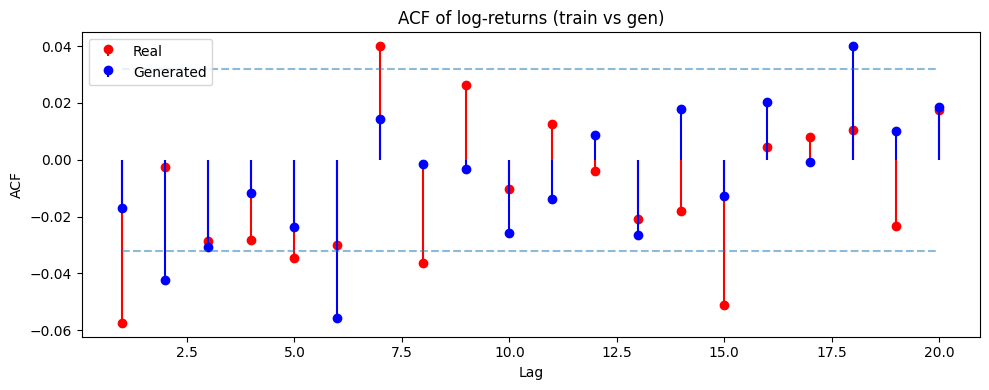

C:\Users\SKY-ex\AppData\Local\Temp\ipykernel_27848\3385731889.py:124: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, acf2_r, linefmt='r-', markerfmt='ro', basefmt=" ", use_line_collection=True, label="Real")
C:\Users\SKY-ex\AppData\Local\Temp\ipykernel_27848\3385731889.py:125: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, acf2_g, linefmt='b-', markerfmt='bo', basefmt=" ", use_line_collection=True, label="Generated")


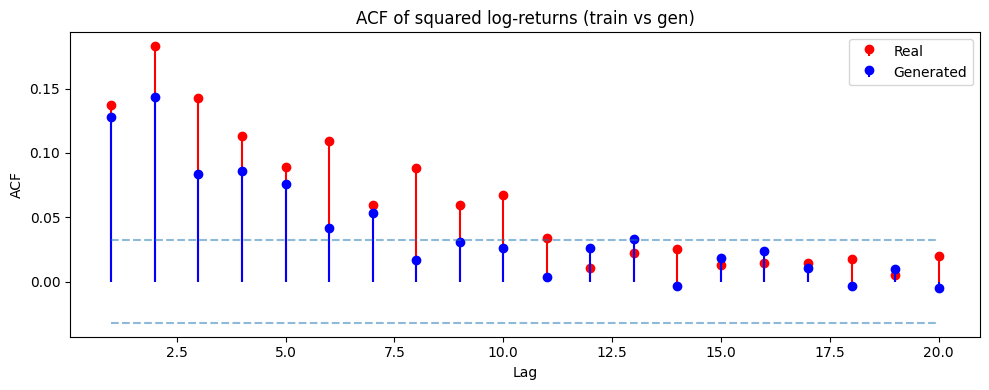

L2 distance (ACF returns): 0.02572290712585266
L2 distance (ACF squared returns): 0.03300785292240149
Ljung–Box returns p-values (real/gen): 5.353492599566279e-43 1.8289789084135382e-19
Ljung–Box squared p-values (real/gen): 0.0 7.383906359507865e-266
Median per-path LB p-value (returns): real= 0.6377852084533682  gen= 0.23916506373438978


In [49]:
# real_paths_idx and gen_paths_idx are lists of arrays (>0), e.g. rebased price paths p/p[0]
res = autocorr_evaluation(true_paths_multi, all_hybrid_paths_multi, max_lag=20, plot=True, title_suffix="(train vs gen)")

print("L2 distance (ACF returns):", res["l2_distance_acf"])
print("L2 distance (ACF squared returns):", res["l2_distance_acf_sq"])
print("Ljung–Box returns p-values (real/gen):", res["ljung_box_returns"]["p_real"], res["ljung_box_returns"]["p_gen"])
print("Ljung–Box squared p-values (real/gen):", res["ljung_box_sq_returns"]["p_real"], res["ljung_box_sq_returns"]["p_gen"])

# Optional per-path summary:
pvals_real = per_path_ljung_box(true_paths_multi, h=20, squared=False)
pvals_gen  = per_path_ljung_box(all_hybrid_paths_multi,  h=20, squared=False)
print("Median per-path LB p-value (returns): real=", np.median(pvals_real), " gen=", np.median(pvals_gen))


## Method 4: ML